# Single neuron activity analysis

By Charles Xu @ DJA Lab, Caltech

Performs average activity tuning analysis for single neurons.

## Set up environment
### Import packages

In [1]:
# Import packages
# numpy
import numpy as np

# scipy
import scipy.io as sio
from scipy.io import loadmat
from scipy.io import savemat

# sklearn
import sklearn
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
%matplotlib inline
# %matplotlib notebook

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

# System
import sys

# Custom packages
# if '/Path/to/Package' not in sys.path:
#     sys.path.insert(0, '/Path/to/Package')
# import colormaps as cmaps # custom colormaps (see: https://gist.github.com/justiceamoh/0aca7df49c35fc0a38d2)


### Helper functions

In [2]:
# Tuning analysis functions
# Define function to perform k-means with silhouette analysis
def plot_kmeans_silhouette(range_n_clusters, data):
    """
    range_n_clusters: ndarray of size (n_clusters,)
        An array of the number of clusters to try
    data: ndarray of size (n_samples, n_features)
        Data to perform k-means clustering and silhouette analysis on
    """
    n_samples = data.shape[0]
    num_clusters = len(range_n_clusters)
    silhouette_scores = []
    fig, axs = plt.subplots(nrows=num_clusters, ncols=2, figsize=(10, 4*num_clusters), constrained_layout=True)
    for i in range(num_clusters):
        n_clusters = range_n_clusters[i]
        axs[i, 0].set_xlim([-0.1, 1])
        axs[i, 0].set_ylim([0, n_samples + (n_clusters + 1) * 10])

        # Fit the KMeans model and calculate silhouette scores
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
        cluster_labels = kmeans.labels_
        silhouette_score_value = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_score_value)
        silhouette_scores.append(silhouette_score_value)
        silhouetee_samples = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for n in range(n_clusters):
            nth_cluster_silhouette_values = silhouetee_samples[cluster_labels == n] # Aggregate the silhouette scores for samples belonging to cluster n
            nth_cluster_silhouette_values.sort() # Sort the silhouette scores

            nth_cluster_size = nth_cluster_silhouette_values.shape[0] # Get the size of cluster n
            y_upper = y_lower + nth_cluster_size # Set the position of the silhouette plot for cluster n
            color = cm.nipy_spectral(float(n) / n_clusters)
            axs[i, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, nth_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            axs[i, 0].text(-0.05, y_lower + 0.5 * nth_cluster_size, str(n)) # Label the silhouette plots with their cluster numbers at the middle

            y_lower = y_upper + 10

        axs[i, 0].set_title("Silhouette plot for the various clusters (n_clusters = %d)" % n_clusters)
        axs[i, 0].set_xlabel("Silhouette coefficient values")
        axs[i, 0].set_ylabel("Cluster label")

        axs[i, 0].axvline(x=silhouette_score_value, color="red", linestyle="--")
        axs[i, 0].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i, 0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot the cluster
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        if data.shape[1] == 2:
            axs[i, 1].scatter(data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = kmeans.cluster_centers_
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("Visualization of the clustered data (n_clusters = %d)" % n_clusters)
            axs[i, 1].set_xlabel("1st feature in feature space")
            axs[i, 1].set_ylabel("2nd feature in feature space")

        else:
            pca = PCA(n_components=2).fit(data)
            data_pca = pca.transform(data)
            axs[i, 1].scatter(data_pca[:, 0], data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = pca.transform(kmeans.cluster_centers_)
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("The visualization of the clustered data.")
            axs[i, 1].set_xlabel("PC1 in PCA mapping of feature space")
            axs[i, 1].set_ylabel("PC2 in PCA mapping of feature space")

        plt.suptitle(
            "k-means clustering with Sillhouette analysis",
            fontsize=14,
            fontweight="bold",
        )

    print("The number of clusters that maximizes silhouette score is: ", range_n_clusters[np.argmax(silhouette_scores)])
    return fig, axs, range_n_clusters[np.argmax(silhouette_scores)]

# Define function to cluster neurons
def fit_kmeans(n_clusters, data, neuron_ids=None):
    """
    n_clusters: int
        Number of clusters to group neurons into
    data: ndarray of size (n_samples, n_features)
        Data to cluster
    neuron_ids: nddarray of size (n_neurons, )
        Neuron IDs
    """
    # Fit k-means clustering with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    cluster_labels = kmeans.labels_

    # Group neurons by cluster
    data_reordered = np.zeros_like(data)
    neuron_ids_reordered = np.zeros_like(cluster_labels)
    n_ith_cluster_lower = 0
    n_ith_cluster_upper = 0
    for i in range(n_clusters):
        n_ith_cluster_upper = n_ith_cluster_lower + sum(cluster_labels == i)
        data_reordered[n_ith_cluster_lower:n_ith_cluster_upper, :] = data[cluster_labels == i, :]
        if neuron_ids is None:
            neuron_ids_reordered[n_ith_cluster_lower:n_ith_cluster_upper] = np.where(cluster_labels == i)[0] + 1
        else:
            neuron_ids_reordered[n_ith_cluster_lower:n_ith_cluster_upper] = neuron_ids[np.where(cluster_labels == i)] + 1
        n_ith_cluster_lower = n_ith_cluster_upper

    return cluster_labels, data_reordered, neuron_ids_reordered

### User inputs

In [16]:
# User inputs
datafile = r'data/EG1-1_fasted_unreg_preprocessed_use.mat' # Specify data file to load

specifylabels = False # boolean, whether to specify behavior labels
if specifylabels:
    labels_ref = ['baseline',
                  'introduction',
                  'sniffM',
                  'attack',
                  'food_approach',
                  'food_sniff',
                  'eating'] # Specify behavior labels (name and order matters!
    #If you are not sure, load the data first and check!)

group_labels = [1, 2, 4, 7] # Indices of the first behavior in each group

specifynclusters = False # boolean, whether to specify number of clusters;
                         # if False, will use number of clusters that maximizes silhouette score
if specifynclusters:
    n_clusters = 5 # Specify number of clusters to group neurons into

savefigure = False # boolean, whether to save figures
if savefigure:
    savefigure_folder = r'figures' # Specify folder to save figures to

tuning_threshold = 1 # Number of z-scores, threshold for determining whether a neuron is tuned to a behavior


#### Colors

In [17]:
# Specify colors for plotting behaviors
# color_names_beh = ["white",
#                    "red",
#                    "orange",
#                    "faded green",
#                    "windows blue"]
# colors_beh = sns.xkcd_palette(color_names_beh)
# cmap_beh = ListedColormap(colors_beh)

redmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', ['white', 'tab:red'], N=3)

orangemap = mcolors.LinearSegmentedColormap.from_list('my_cmap', ['white', 'tab:orange'], N=4)

beh_colors = ['tab:blue',
              'tab:green',
              mcolors.to_hex(redmap(1/(redmap.N-1))), 'tab:red',
              mcolors.to_hex(orangemap(1/(orangemap.N-1))), mcolors.to_hex(orangemap(2/(orangemap.N-1))), 'tab:orange']

beh_raster_colors = ['white',
                     'tab:green',
                     mcolors.to_hex(redmap(1/(redmap.N-1))), 'tab:red',
                     mcolors.to_hex(orangemap(1/(orangemap.N-1))), mcolors.to_hex(orangemap(2/(orangemap.N-1))), 'tab:orange'] # Colors for behavior raster

beh_raster_cmap = ListedColormap(beh_raster_colors)

ytickcolors = ['tab:blue',
                'tab:green',
                'tab:red', 'tab:red',
                'tab:orange', 'tab:orange', 'tab:orange']

pie_colors = ['tab:red', 'tab:brown', 'tab:orange', 'grey']


### Load data

Preprocessing is done with MATLAB using preprocessHangryMice.m. The script performs these actions:
1. Manually define behavioral label alignment and grouping.
2. Fill in behavioral data for missing labels with zeros.
3. Combine/merge stimuli labels and data.
4. Smooth neural data.
5. Save preprocessed data to .mat file.

The preprocessed data consists of the following necessary variables:
- neuralDataPreprocessed: array of size (n_neurons, n_samples). Smoothed neural data
- behaviorDataPreprocessed: array of size (n_behaviors, n_samples). Behavior data
- behaviorLabelsPreprocessed: cell array of size (n_behaviors, ). Behavior labels
- stimuliDataPreprocessed: array of size (n_stimuli, n_samples). Stimuli data
- stimuliLabelsPreprocessed: cell array of size (n_stimuli, ). Stimuli labels
- (optional) neuralData: array of size (n_neurons, n_samples). Raw neural data
Note: If compare across both conditions, make sure the labels from the two datasets match. Fill in the missing data with all zeros

In [18]:
mat = sio.loadmat(datafile) # Load data

input_raw = mat['behaviorDataPreprocessed'] # Behavior data

output_raw = np.array(mat['neuralDataPreprocessed']) # Neural data

labels_raw = mat['behaviorLabelsPreprocessed'] # Behavior labels
labels = [] # Behavior labels
for i in range(len(labels_raw)):
    labels.append(labels_raw[i][0][0])

stimuli = mat['stimuliDataPreprocessed'] # Stimuli
stimuli_labels_raw = mat['stimuliLabelsPreprocessed'] # Stimuli labels
stimuli_labels = []
for i in range(len(stimuli_labels_raw)):
    stimuli_labels.append(stimuli_labels_raw[i][0][0])

if specifylabels:
    if all(label in labels for label in labels_ref):
        input_raw = input_raw[[labels.index(label) for label in labels_ref]]
        labels = labels_ref

print(f'Number of input variables: {input_raw.shape[0]}')
print(f'Length of session: {input_raw.shape[1]}')
print(f'The input variables are: {labels}')
print(f'Number of output variables: {output_raw.shape[0]}')
print(f'Number of stimuli variables: {stimuli.shape[0]}')
print(f'The stimuli variables are: {stimuli_labels}')


Number of input variables: 8
Length of session: 6392
The input variables are: ['baseline', 'introduction', 'sniffM', 'attack', 'food_approach', 'food_sniff', 'eating', 'drinking']
Number of output variables: 144
Number of stimuli variables: 3
The stimuli variables are: ['baseline', 'male', 'food']


## Process data

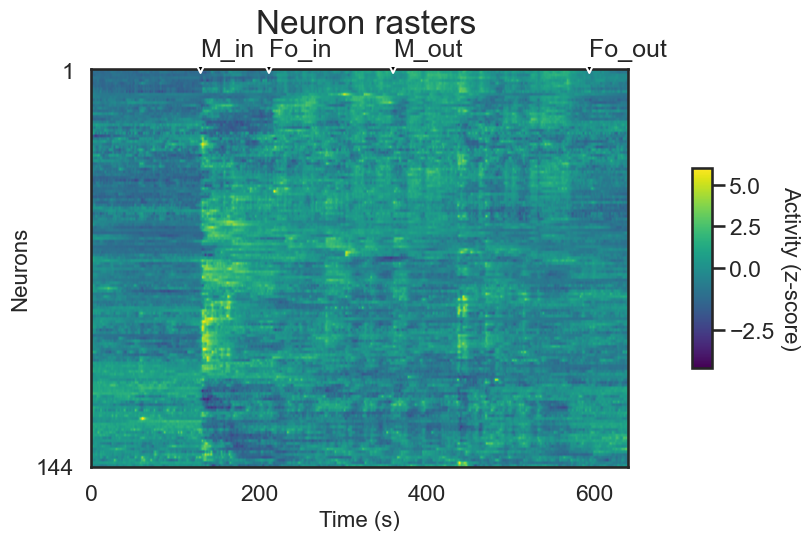

In [19]:
# Plot raw neuron rasters
time = output_raw.shape[1]

fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)

# Determine the color scale based on the min and max of both datasets
vmin = output_raw.min()
vmax = output_raw.max()

# Create a diverging color map normalized around 0
divnorm = mcolors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=6)

# Plot the neuron raster for the M1 condition
im = ax.imshow(output_raw, cmap='viridis', aspect='auto', norm=divnorm)
ax.set_xticks(np.arange(time, step=2000))
ax.set_xticklabels(np.arange(time, step=2000)//10)
ax.set_xlabel('Time (s)', fontsize=16)
ax.set_yticks([0, output_raw.shape[0]-1])
ax.set_yticklabels([1, output_raw.shape[0]])
ax.set_ylabel('Neurons', fontsize=16)

# Add stimuli annotations
stim_time = []
stim_annot = ['M_in', 'M_out', 'Fo_in', 'Fo_out']
for i, stim in enumerate(stimuli_labels):
    if stim == 'male':
        male = stimuli[i]
        indices = np.argwhere(male)
        stim_time.append(indices[0][0])
        stim_time.append(indices[-1][0])
    if stim == 'food':
        food = stimuli[i]
        indices = np.argwhere(food)
        stim_time.append(indices[0][0])
        stim_time.append(indices[-1][0])

plt.suptitle('Neuron rasters', fontsize=24, x=0.45, y=1.05)

for i, t, label in zip(range(len(stim_time)), stim_time, stim_annot):
    ax.annotate(label, xy=(t, 1), xytext=(t, -5), arrowprops=dict(facecolor='black', headwidth=5, headlength=5, width=0))

# Add a colarbar
cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Activity (z-score)', rotation=-90, va="bottom", fontsize=16)

# Save figure
if savefigure:
    fig.savefig(f'{savefigure_folder}/NeuronRaster.svg')

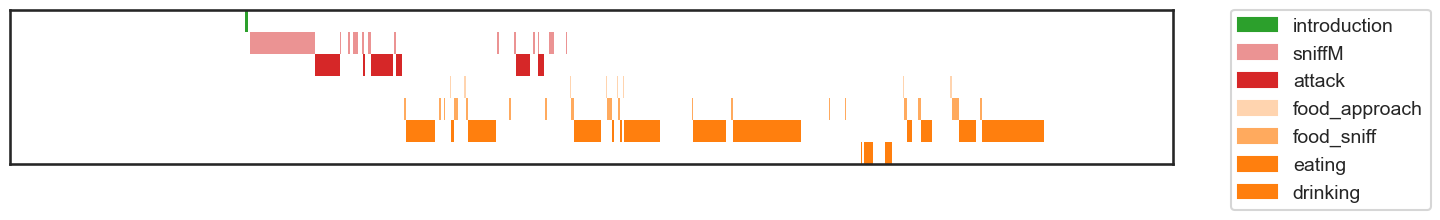

In [20]:
# Make behavior raster
beh_raster = np.zeros((len(labels)-1, input_raw.shape[1]), dtype=int)
for i in range(len(labels)-1):
    beh_raster[i, :] = input_raw[i+1, :]*(i+1)

fig, ax = plt.subplots(figsize=(15, 2))
ax.imshow(beh_raster, aspect="auto", cmap=beh_raster_cmap, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])

# Define the labels and colors for your legend
beh_legend_labels = labels[1:]
beh_legend_colors = [beh_raster_cmap(i) for i in range(1, len(labels))]

# Create a list of Patch objects for the legend
patches = [mpatches.Patch(color=beh_legend_colors[i], label=beh_legend_labels[i]) for i in range(len(beh_legend_colors))]

# Add the legend to the plot
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)

# Save figure
if savefigure:
    fig.savefig(f'{savefigure_folder}/BehaviorRasters.svg')

#### Compute mean activity for each neuron and each behavior

In [21]:
n_labels = len(labels)
n_neurons = output_raw.shape[0]
mean_activity = np.zeros((n_labels, n_neurons))
for l in range(n_labels):
    mean_activity[l,:] = np.nan_to_num(np.mean(output_raw[:,np.where(input_raw[l,:] == 1)[0]], axis=1))

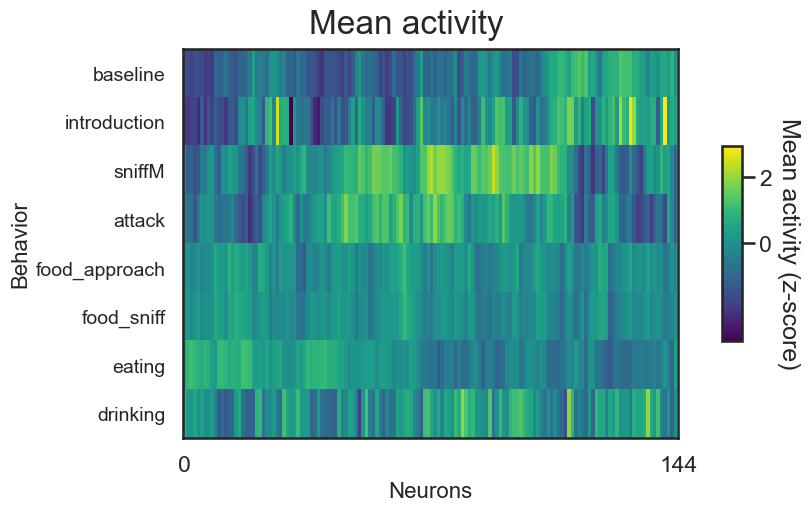

In [22]:
# Plot mean activity
fig, ax = plt.subplots(ncols = 1, figsize=(8, 5), constrained_layout=True)

# Determine the color scale based on the min and max of both datasets
vmin = mean_activity.min()
vmax = mean_activity.max()
divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im = ax.imshow(mean_activity, cmap='viridis', aspect='auto', interpolation='none', norm=divnorm)
# axs[0].set_xticks(np.arange(n_neurons_M1, step=10))
# axs[0].set_xticklabels(np.arange(n_neurons_M1, step=10)+1)
ax.set_xticks([0, n_neurons])
ax.set_xlabel('Neurons', fontsize=16)
ax.set_yticks(np.arange(n_labels))
ax.set_yticklabels(labels, fontsize=14)
ax.set_ylabel('Behavior', fontsize=16)

# Add a colarbar
cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")

plt.suptitle('Mean activity', fontsize=24)

# Save figure
if savefigure:
    fig.savefig(f'{savefigure_folder}/MeanActivity.svg')

##### Baseline subtracted

In [23]:
# Subtract baseline from other behaviors
mean_activity_nb = np.zeros((n_labels, n_neurons))
for i in range(n_labels):
    mean_activity_nb[i,:] = mean_activity[i,:] - mean_activity[0,:]

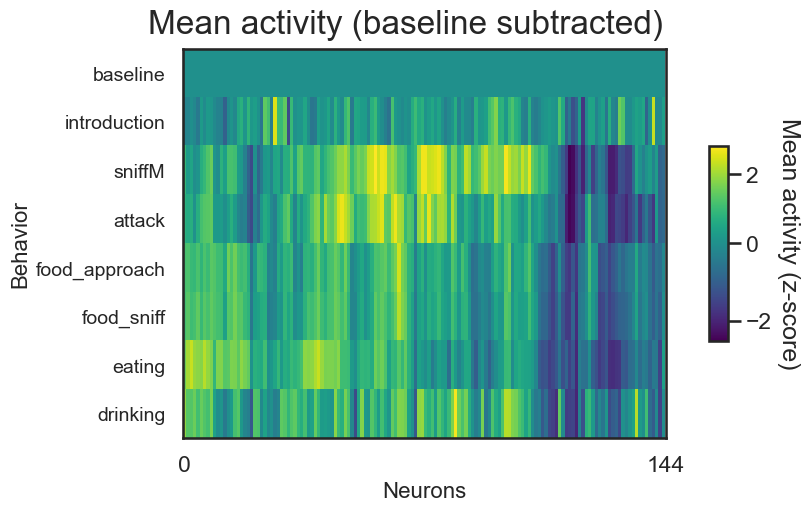

In [24]:
# Plot mean activity
fig, ax = plt.subplots(ncols = 1, figsize=(8, 5), constrained_layout=True)

# Determine the color scale based on the min and max of both datasets
vmin = mean_activity_nb.min()
vmax = mean_activity_nb.max()
divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im = ax.imshow(mean_activity_nb, cmap='viridis', aspect='auto', interpolation='none', norm=divnorm)
ax.set_xticks([0, n_neurons])
ax.set_xlabel('Neurons', fontsize=16)
ax.set_yticks(np.arange(n_labels))
ax.set_yticklabels(labels, fontsize=14)
ax.set_ylabel('Behavior', fontsize=16)

# Add a colarbar
cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")

plt.suptitle('Mean activity (baseline subtracted)', fontsize=24)

# Save figure
if savefigure:
    fig.savefig(f'{savefigure_folder}/MeanActivityNB.svg')

## Cluster neurons

In [25]:
# Perform k-means with silhouette analysis
range_n_clusters = np.arange(2, n_labels+1) # Generate range of number of clusters to evaluate
fig, axs, n_clusters = plot_kmeans_silhouette(range_n_clusters, mean_activity.T)
plt.close(fig)

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/

For n_clusters = 2 the average silhouette_score is : 0.2635957793433824
For n_clusters = 3 the average silhouette_score is : 0.2694747045004175
For n_clusters = 4 the average silhouette_score is : 0.24719305481930912
For n_clusters = 5 the average silhouette_score is : 0.22988268146811652


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 the average silhouette_score is : 0.2192311410172594
For n_clusters = 7 the average silhouette_score is : 0.21417659819622145
For n_clusters = 8 the average silhouette_score is : 0.1921172662999608
The number of clusters that maximizes silhouette score is:  3


#### Baseline subtracted

In [26]:
mean_activity_nb = mean_activity_nb[1:,:]


In [27]:
# Perform k-means with silhouette analysis
range_n_clusters = np.arange(2, n_labels+1) # Generate range of number of clusters to evaluate
fig, axs, n_clusters_nb = plot_kmeans_silhouette(range_n_clusters, mean_activity_nb.T)
plt.close(fig)

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/

For n_clusters = 2 the average silhouette_score is : 0.4369646542328726
For n_clusters = 3 the average silhouette_score is : 0.2529861973328139
For n_clusters = 4 the average silhouette_score is : 0.26046218611142125
For n_clusters = 5 the average silhouette_score is : 0.22881820254493357


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 the average silhouette_score is : 0.24111768709106313
For n_clusters = 7 the average silhouette_score is : 0.2308835605977609
For n_clusters = 8 the average silhouette_score is : 0.21375422322804322
The number of clusters that maximizes silhouette score is:  2


## Generate raster plots

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


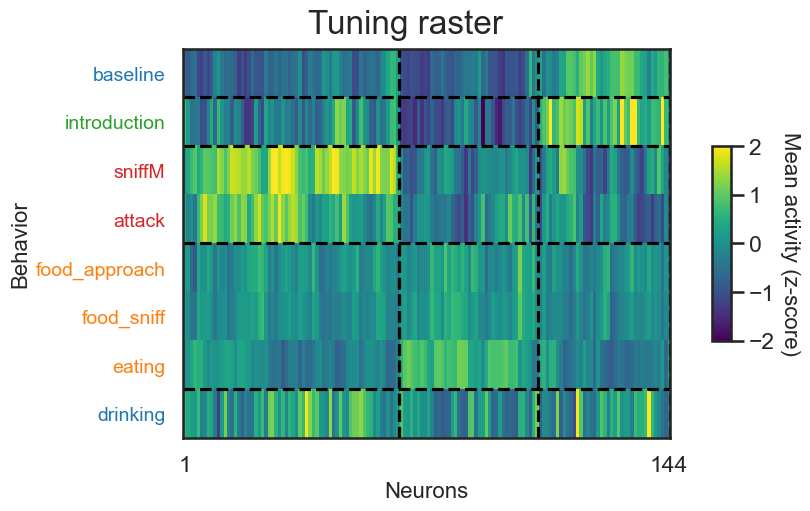

In [28]:
# Plot tuning raster
# Fit k-means clustering
if specifynclusters:
    n_clusters = specifynclusters
cluster_labels, data_reordered, neuron_ids_reordered = fit_kmeans(n_clusters, mean_activity.T)

# Reorder the cluster again
cluster_order = [1, 3, 0, 2, 4] # Reorder the clusters a posteriori

i_cluster_lower = 0
for i, i_cluster in enumerate(cluster_order):
    i_cluster_upper = i_cluster_lower + sum(cluster_labels == i_cluster)
    data_reordered[i_cluster_lower:i_cluster_upper, :] = mean_activity[:, cluster_labels == i_cluster].T
    i_cluster_lower = i_cluster_upper

# Plot tuning raster
fig, ax = plt.subplots(ncols = 1, figsize=(8, 5), constrained_layout=True)

# Determine the color scale based on the min and max of both datasets
vmin = mean_activity.min()
vmax = mean_activity.max()
divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the first raster
# im0 = axs[0].imshow(data_reordered_M1.T, cmap='coolwarm', aspect='auto', norm=divnorm)
im = ax.imshow(data_reordered.T, cmap='viridis', interpolation='none', aspect='auto', vmin=-2, vmax=2)
ax.set_xticks([0, n_neurons-1])
ax.set_xticklabels([1, n_neurons])
ax.set_xlabel('Neurons', fontsize=16)
ax.set_yticks(np.arange(n_labels))
ax.set_yticklabels(labels, fontsize=14)
ax.set_ylabel('Behavior', fontsize=16)

# Separate clusters
vline_x = 0
for c in cluster_order:
    vline_x += sum(cluster_labels == c)
    ax.axvline(x=vline_x - 1/2, color='black', linestyle='--')

# for i in range(1, n_clusters_M1):
#     axs[0].axvline(x=np.sum(cluster_labels_M1 < i) - 1/2, color='black', linestyle='--')

# Separate behaviors
for b in group_labels:
    ax.axhline(y=b-1/2, color='black', linestyle='--')

# Get the yticklabels and set their color
for i, yticklabel in enumerate(ax.get_yticklabels()):
    yticklabel.set_color(ytickcolors[i % len(ytickcolors)])

# Add a colarbar
cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom", fontsize=16)

plt.suptitle('Tuning raster', fontsize=24)

# Save figure
if savefigure:
    fig.savefig(f'{savefigure_folder}/TuningRaster.svg')

In [29]:
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2], dtype=int32)

#### Baseline subtracted

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


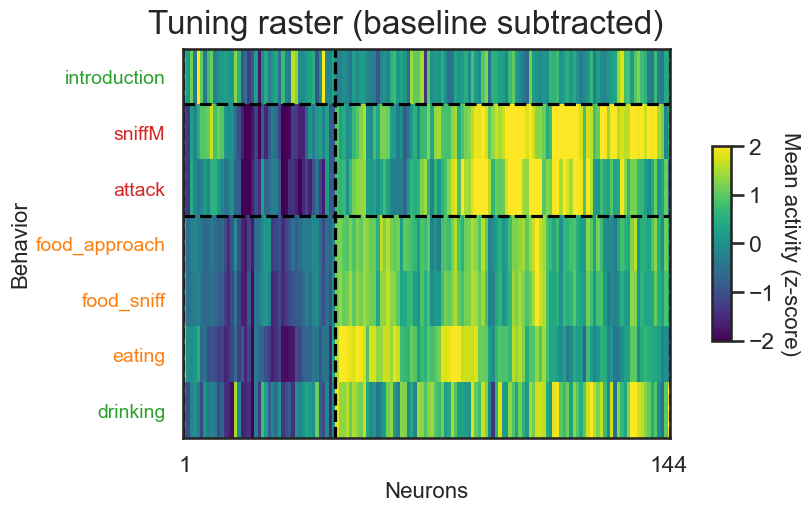

In [30]:
# Plot tuning raster
# Fit k-means clustering
if specifynclusters:
    n_clusters_nb = specifynclusters
cluster_labels_nb, data_reordered_nb, neuron_ids_nb_reordered = fit_kmeans(n_clusters_nb, mean_activity_nb.T)

# Reorder the cluster again
cluster_order_nb = [2, 0, 3, 1]
# cluster_order_nb = [0, 1, 2, 3, 4]

i_cluster_lower = 0
for i, i_cluster in enumerate(cluster_order_nb):
    i_cluster_upper = i_cluster_lower + sum(cluster_labels_nb == i_cluster)
    data_reordered_nb[i_cluster_lower:i_cluster_upper, :] = mean_activity_nb[:, cluster_labels_nb == i_cluster].T
    i_cluster_lower = i_cluster_upper

# Plot tuning raster
fig, ax = plt.subplots(ncols = 1, figsize=(8, 5), constrained_layout=True)

# Determine the color scale based on the min and max of both datasets
vmin = mean_activity_nb.min()
vmax = mean_activity_nb.max()
divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the first raster
im = ax.imshow(data_reordered_nb.T, cmap='viridis', interpolation='none', aspect='auto', vmin=-2, vmax=2)
ax.set_xticks([0, n_neurons-1])
ax.set_xticklabels([1, n_neurons])
ax.set_xlabel('Neurons', fontsize=16)
ax.set_yticks(np.arange(n_labels-1))
ax.set_yticklabels(labels[1:], fontsize=14)
ax.set_ylabel('Behavior', fontsize=16)

# Separate clusters
vline_x = 0
for c in cluster_order_nb:
    vline_x += sum(cluster_labels_nb == c)
    ax.axvline(x=vline_x - 1/2, color='black', linestyle='--')

# Separate behaviors
group_indices = [1, 3] # Indices of the first behavior in each group
for b in group_indices:
    ax.axhline(y=b-1/2, color='black', linestyle='--')

# Color the yticklabels
ytickcolors_nb = ['tab:green',
               'tab:red', 'tab:red',
               'tab:orange', 'tab:orange', 'tab:orange']

# Get the yticklabels and set their color
for i, yticklabel in enumerate(ax.get_yticklabels()):
    yticklabel.set_color(ytickcolors_nb[i % len(ytickcolors_nb)])

# Add a colarbar
cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom", fontsize=16)

plt.suptitle('Tuning raster (baseline subtracted)', fontsize=24)

# Save figure
if savefigure:
    fig.savefig(f'{savefigure_folder}/TuningRasterNB.svg')

In [31]:
cluster_labels_nb

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## Make pie chart for male vs food populations

In [32]:
labels

['baseline',
 'introduction',
 'sniffM',
 'attack',
 'food_approach',
 'food_sniff',
 'eating',
 'drinking']

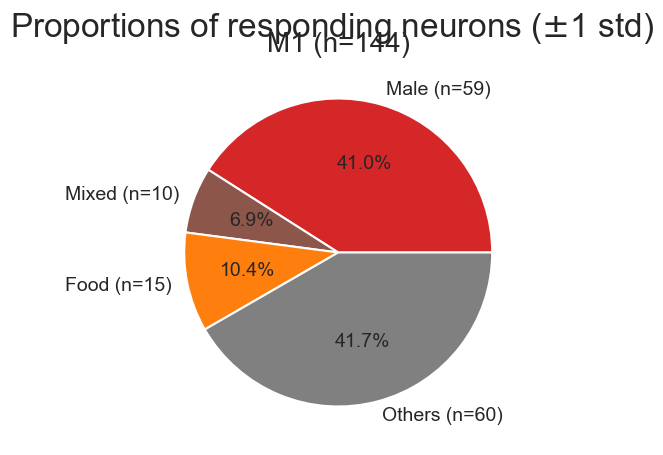

In [33]:
# Make pie charts for male and food responsive neurons
tuning_threshold = 1 # Threshold for determining whether a neuron is tuned to a behavior

# For M1
male_responsive = np.any((mean_activity[2:4, :] > tuning_threshold) | (mean_activity[2:4, :] < -tuning_threshold), axis=0) # Select the rows for male-responsive behaviors
food_responsive = np.any((mean_activity[4:, :] > tuning_threshold) | (mean_activity[4:, :] < -tuning_threshold), axis=0) # Select the rows for food-responsive behaviors
mixed_responses = male_responsive & food_responsive
others = ~male_responsive & ~food_responsive
counts = [np.sum(male_responsive)-np.sum(mixed_responses), np.sum(mixed_responses), np.sum(food_responsive)-np.sum(mixed_responses), np.sum(others)]

# Create labels
pie_labels = [f'Male (n={counts[0]})', f'Mixed (n={counts[1]})', f'Food (n={counts[2]})', f'Others (n={counts[3]})']

# Create a new figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot the pie charts
ax.pie(counts, labels=pie_labels, autopct='%1.1f%%', colors=pie_colors, textprops={'fontsize': 14})

plt.suptitle('Proportions of responding neurons ($\pm$1 std)', fontsize=24)

# Save figure
if savefigure:
    fig.savefig(f'{savefigure_folder}/TuningProportions.svg')

## Behavior durations

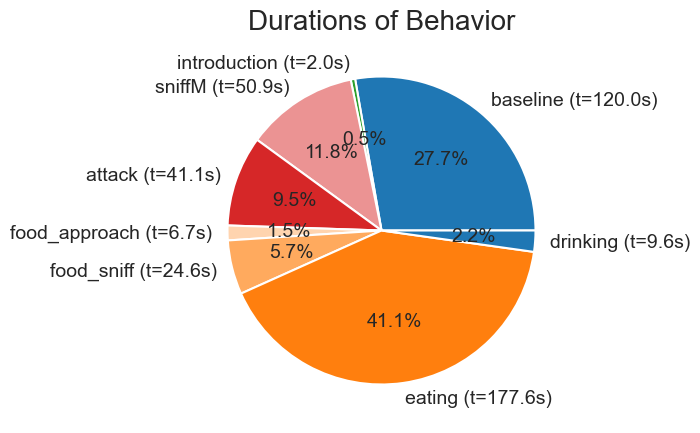

In [34]:
beh_duration = np.zeros(len(labels))
for i in range(len(labels)):
    beh_duration[i] = np.sum(input_raw[i, :])

beh_duration_labels = [f'{beh} (t={beh_duration[i]/10}s)' for i, beh in enumerate(labels)]

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].pie(beh_duration_M1, labels=beh_duration_labels_M1, autopct='%1.1f%%', colors=beh_colors, textprops={'fontsize': 14})
# axs[0].set_title('M1', fontsize=20)
# axs[1].pie(beh_duration_M2, labels=beh_duration_labels_M2, autopct='%1.1f%%', colors=beh_colors, textprops={'fontsize': 14})
# axs[1].set_title('M2', fontsize=20)

fig = plt.figure(figsize=(8, 5))
plt.pie(beh_duration, labels=beh_duration_labels, autopct='%1.1f%%', colors=beh_colors, textprops={'fontsize': 14})
plt.title('Durations of Behavior', fontsize=20)

# Save figure
if savefigure:
    plt.savefig(f'{savefigure_folder}/BehaviorDuration.svg')

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].bar(range(len(labels)), beh_duration_M1, color=ytickcolors)
# axs[0].set_title('M1', fontsize=20)
# axs[0].set_xticks(range(len(labels)))
# axs[0].set_xticklabels(labels, fontsize=14)

# axs[1].bar(range(len(labels)), beh_duration_M2, color=ytickcolors)
# axs[1].set_title('M2', fontsize=20)
# axs[1].set_xticks(range(len(labels)))
# axs[1].set_xticklabels(labels, fontsize=14)